In [2]:
import pandas as pd
import time
import datetime
import numpy as np


import prob_tree
import kTree
import csv
from fractions import Fraction
import graphviz
import tree
from kTree import ktree_main

import sys
import generators
import numpy as np
import math
from data import Data
from datetime import datetime, timedelta

import os
import pickle
import json
import matplotlib.pyplot as plt



date_test='20190611'
data_test = pd.read_csv('./input_data/Future/'+str(date_test)+'/IH1906.CFFEX.txt',header=0)

# data_test = pd.read_csv('./input_data/Future/20180105/IH1801.CFFEX.txt',header=0)


In [20]:
#Simulate the market making process, construct strategy based on the market making position
def mkt_making_position_stgy(date_test):
    data_test = pd.read_csv('./input_data/Future/'+str(date_test)+'/IH1906.CFFEX.txt',header=0)
    
    data_test_valid = data_test.loc[data_test[data_test['Ask1Qty']!=0].index,]
    data_test_valid = data_test_valid.set_index('ExchangeTime')
    data_test_valid.dtypes
    data_test_valid['Ask1Price']=pd.to_numeric(data_test_valid['Ask1Price'])
    data_test_valid['Bid1Price']=pd.to_numeric(data_test_valid['Bid1Price'])
    #print(data_train_valid.dtypes[1:18])
    #print(len(data_test_valid))
    data_test_valid.drop(data_test_valid.index[0],inplace=True)
    #data_test_valid.head()
    
    data_test_simulation=data_test_valid[['LastPrice','LastQty','Bid1Price','Ask1Price']]
    data_test_simulation['FairPrice']=(data_test_valid['Ask1Price']*data_test_valid['Bid1Qty']+data_test_valid['Bid1Price']*data_test_valid['Ask1Qty'])/(data_test_valid['Ask1Qty']+data_test_valid['Bid1Qty'])
    i=0
    while True:
        if i == (data_test_simulation.shape[0]-1): break
        if ((data_test_simulation.index[i+1]-data_test_simulation.index[i]>500000) & (data_test_simulation.index[i+1]-data_test_simulation.index[i]<600000000)):
            diff_num = int((data_test_simulation.index[i+1]-data_test_simulation.index[i])/500000)
            for ins in range(1,diff_num):
                above = data_test_simulation[:i+ins]
                below = data_test_simulation[i+ins:]
                insert = data_test_simulation[i:i+1]
                above_ind = data_test_simulation.index.values[:i+ins].tolist()
                below_ind = data_test_simulation.index.values[i+ins:].tolist()
                insert_ind = data_test_simulation.index[i]+500000*ins
                data_test_simulation = above.append(insert,ignore_index=True).append(below,ignore_index=True)
                above_ind.append(insert_ind)
                above_ind.extend(below_ind)
                data_test_simulation.index=above_ind
        i=i+1
        #print(i)
    # name = './output/market_making_'+str(date_test)+'.txt'
    # f = open(name, "wb")  
    # pickle.dump(data_test_simulation, f)
    # f.close()

#     f = open('./output/market_making_'+str(date_test)+'.txt', "rb")  
#     data_test_simulation=pickle.load(f)
#     f.close()
#     print(type(data_test_simulation))
#     data_test_simulation.head()

    return_freq=1
    return_test=[0 for x in range(return_freq) ]
    price_test=data_test_simulation['FairPrice']
    price_test_1 = price_test[:(len(price_test)-return_freq)]
    price_test_2 = price_test[return_freq:len(price_test)]
    price_test_1.index = price_test_2.index
    return_test_=(price_test_2/price_test_1-1)*100
    return_test_ = return_test_.tolist()
    return_test=return_test+return_test_
    len(return_test)


    from pandas.core.frame import DataFrame

    margin=0.05
    ElasticFuture=0.1
    MaxPos=5000000000000
    PropSize=2
    LenTest=data_test_simulation.shape[0]

    TradePrice=[data_test_simulation['FairPrice'].iloc[0]-1*0*ElasticFuture]
    position=[0]
    PtfValue=[0]
    BidProp=[0]
    AskProp=[0]
    StgyPnl=[0]
    stgy_add=0
    ptf_value=0
    pos0=0
    pos1=0
    bid_prop=0
    ask_prop=0
    poscum=0
    poscum_stgy=0
    ewm_short_list=[]
    ewm_long_list=[]

    beta=5

    price_list=[]

    for i in range(1,LenTest-1):
    #     print(price_list)
    #     print(pos0)
    #     print(ptf_value)
    #     print('BidPrice',data_test_simulation['Bid1Price'].iloc[i])
    #     print('AskPrice',data_test_simulation['Ask1Price'].iloc[i])

        signal=10*return_test[i]+9*return_test[i-1]+8*return_test[i-2]+7*return_test[i-3]+\
        6*return_test[i-4]+5*return_test[i-5]+4*return_test[i-6]+3*return_test[i-7]+\
        2*return_test[i-8]+1*return_test[i-9]

        #ptf_value = ptf_value+pos0*(data_test_simulation['FairPrice'].iloc[i]-data_test_simulation['FairPrice'].iloc[i-1]) ###???which price to use

        trade_price = data_test_simulation['FairPrice'].iloc[i]-beta*signal

    #     trade_price = data_test_simulation['FairPrice'].iloc[i]-1*pos0*ElasticFuture

        #judge if we realise some trades
        #buy
        if(bid_prop!=0 and data_test_simulation['LastPrice'].iloc[i]<=data_test_simulation['Bid1Price'].iloc[i-1]):
            qty=min(bid_prop,data_test_simulation['LastQty'].iloc[i]-data_test_simulation['LastQty'].iloc[i-1],max(0,MaxPos-pos0))
            pos1=pos0+qty
            if(len(price_list)!=0 and price_list[0]<0):
                if(len(price_list)>=qty):
                    for j in range(qty):
                        ptf_value=ptf_value+(-price_list[0])-data_test_simulation['Bid1Price'].iloc[i]
                        price_list.pop(0)
                else:
                    len_price_list=len(price_list)
                    for j in range(len_price_list):
                        ptf_value=ptf_value+(-price_list[0])-data_test_simulation['Bid1Price'].iloc[i]
                        price_list.pop(0)
                    for j in range(qty-len_price_list):
                        price_list.append(data_test_simulation['Bid1Price'].iloc[i])
            else:
                for j in range(qty):
                    price_list.append(data_test_simulation['Bid1Price'].iloc[i])
        #sell       
        if(ask_prop!=0 and data_test_simulation['LastPrice'].iloc[i]>=data_test_simulation['Ask1Price'].iloc[i-1]):
            qty=min(ask_prop,data_test_simulation['LastQty'].iloc[i]-data_test_simulation['LastQty'].iloc[i-1],max(0,pos0+MaxPos))
            pos1=pos0-qty
            if(len(price_list)!=0 and price_list[0]>0):
                if(len(price_list)>=qty):
                    for j in range(qty):
                        ptf_value=ptf_value+(-price_list[0])+data_test_simulation['Ask1Price'].iloc[i]
                        price_list.pop(0)
                else:
                    len_price_list=len(price_list)
                    for j in range(len_price_list):
                        ptf_value=ptf_value+(-price_list[0])+data_test_simulation['Ask1Price'].iloc[i]
                        price_list.pop(0)
                    for j in range(qty-len_price_list):
                        price_list.append(-data_test_simulation['Ask1Price'].iloc[i])
            else:
                for j in range(qty):
                    price_list.append(-data_test_simulation['Ask1Price'].iloc[i])


        #judge if or not join best bid/ask
        if (trade_price-margin)>=data_test_simulation['Bid1Price'].iloc[i]:
            bid_prop=PropSize
        else:bid_prop=0
        if (trade_price+margin)<=data_test_simulation['Ask1Price'].iloc[i]:
            ask_prop=PropSize
        else:ask_prop=0

        PtfValue.append(ptf_value)
        TradePrice.append(trade_price)
        position.append(pos1)
        BidProp.append(bid_prop)
        AskProp.append(ask_prop)

        if(i>120):
            position_short=DataFrame(position[-5400:])
            ewm_short=position_short.ewm(alpha=2/(5400+1),adjust=False).mean()[-1:].values[0][0]
            #print("ewm_short:"+str(ewm_short))
            ewm_short_list.append(ewm_short)
            position_long=DataFrame(position[-14400:])
            ewm_long=position_long.ewm(alpha=2/(14400+1),adjust=False).mean()[-1:].values[0][0]
            #print("ewm_long:"+str(ewm_long))
            ewm_long_list.append(ewm_long)
            if(i==121):
                position_stra0=-np.sign(ewm_short-ewm_long)
                sign_ewm=np.sign(ewm_short-ewm_long)
                fairprice_stra=-position_stra0*data_test_simulation['FairPrice'].iloc[i]
            elif((np.sign(ewm_short-ewm_long) != sign_ewm) and (np.sign(ewm_short-ewm_long) != 0) and abs(ewm_short-ewm_long)>10):
                position_stra1=-np.sign(ewm_short-ewm_long)
                poscum_stgy+=abs(position_stra1-position_stra0)
                stgy_add+=fairprice_stra+np.sign(ewm_short-ewm_long)*data_test_simulation['FairPrice'].iloc[i]
                print(i)
                print(position_stra1,poscum_stgy,stgy_add,fairprice_stra,ewm_short-ewm_long,np.sign(ewm_short-ewm_long)*data_test_simulation['FairPrice'].iloc[i])
                sign_ewm=np.sign(ewm_short-ewm_long)
                fairprice_stra=-position_stra1*data_test_simulation['FairPrice'].iloc[i]
                position_stra0=position_stra1  
#                 else:
#                     position_stra0=-np.sign(ewm_short-ewm_long)
#                     sign_ewm=np.sign(ewm_short-ewm_long)
#                     fairprice_stra=-position_stra0*data_test_simulation['FairPrice'].iloc[i]
#                     print(i)
#                     print(position_stra1,stgy_add,fairprice_stra,ewm_short-ewm_long,np.sign(ewm_short-ewm_long)*data_test_simulation['FairPrice'].iloc[i])

        StgyPnl.append(stgy_add)


        #print(i)
        #print(len(position))

        poscum=poscum+abs(pos1-pos0)
        pos0=pos1
        i+=1
    
    poscum_stgy+=1
    stgy_add+=fairprice_stra-np.sign(fairprice_stra)*data_test_simulation['FairPrice'].iloc[-1]
#     print(LenTest-1)
#     print(0,poscum_stgy,stgy_add,fairprice_stra,0,-np.sign(fairprice_stra)*data_test_simulation['FairPrice'].iloc[-1])


    StgyPnl.append(stgy_add)                                                                               
    
    POT=StgyPnl[-1]/poscum_stgy    
    print(poscum_stgy)
    print(POT)

    import matplotlib.pyplot as plt
    plt.plot(StgyPnl)
    plt.xlabel('t')
    plt.ylabel('pnl')
    plt.savefig("pnl_position_simulation_IH"+str(date_test)+".png")
    plt.figure()

    import matplotlib.pyplot as plt
    plt.plot(ewm_short_list,color='red')
    plt.plot(ewm_long_list,color='green')
    plt.xlabel('t')
    plt.ylabel('position')
    plt.savefig("position_ewma_IH"+str(date_test)+".png")
    plt.figure()
    
    plt.plot(position)
    #plt.plot(range(24000,26000),pos[24000:26000])
    plt.xlabel('t')
    plt.ylabel('position')
    #plt.title(name)
    plt.savefig("position_IH"+str(date_test)+".png")
    plt.figure()
    
    plt.plot(data_test_simulation['FairPrice'].values)
    plt.xlabel('t')
    plt.ylabel('FairPrice')
    plt.savefig("fairprice_IH"+str(date_test)+".png")
    plt.figure()

    return poscum_stgy, POT
    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


7516
-1.0 2.0 -17.04615384615363 -2728.846153846154 10.311006033583924 2711.8
3.0
-10.748717948717816


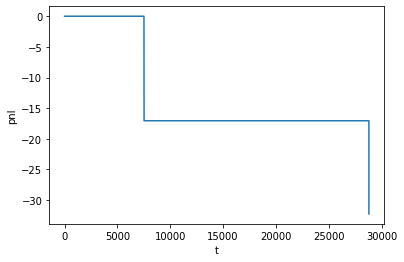

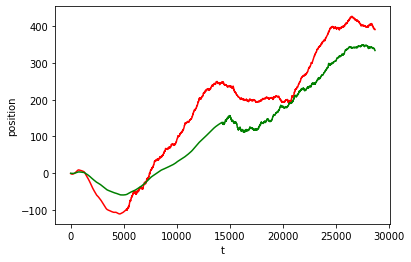

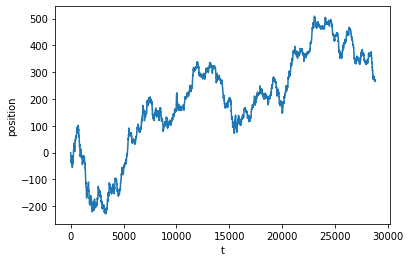

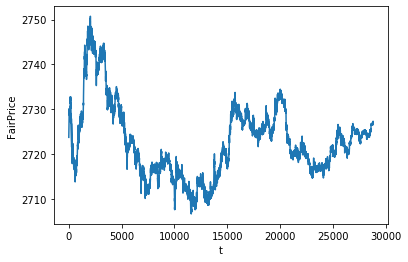

<Figure size 432x288 with 0 Axes>

In [21]:
a,b=mkt_making_position_stgy(20190603)

In [ ]:
date_start=20190603
date_end=20190617
date_test=date_start
poscum_list=[]
pot_list=[]
date_test_list=[]
while date_test<=date_end:
    path = './input_data/Future/'+str(date_test)+'/IH1906.CFFEX.txt'
    if os.access(path, os.F_OK):
        date_test_list.append(date_test)
        poscum_,pot_=mkt_making_position_stgy(date_test)
        poscum_list.append(poscum_)
        pot_list.append(pot_)
        print(date_test)
    date_date = datetime(year=int(str(date_test)[0:4]), month=int(str(date_test)[4:6]), day=int(str(date_test)[6:8]))
    date_date =  date_date+timedelta(days=1) 
    date_test = 10000*date_date.year + 100*date_date.month + date_date.day
    
result=np.vstack((date_test_list,poscum_list,pot_list))
np.savetxt('mkt_making_position_stgy_'+str(date_start)+'_to_'+str(date_end)+'.csv', result, delimiter = ',')